# Setup & ERA5 field → initialize/force SW

In [1]:
# --- Cell 1: setup ---
import sys
from pathlib import Path
ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

import numpy as np

from src.models.sw_adapter import rhs, make_initial_sw, sw_cfl
from src.runner import solve_fixed_step
from src.io.reanalysis import mock_height_anomaly

# grid & base params
Ny, Nx = 64, 96
Lx, Ly = 1.0, 0.75
dx, dy = Lx / Nx, Ly / Ny
g, f, nu = 9.81, 1e-4, 1e-4
h0 = 1.0

# global params (used by Cell 2 as well)
Du, Dv = 1e-3, 1e-3
params = {"g": g, "f": f, "nu": nu, "dx": dx, "dy": dy, "Du": Du, "Dv": Dv}

# optional mock run (off by default)
RUN_MOCK = False
if RUN_MOCK:
    anom = mock_height_anomaly(Ny, Nx, amp=0.05)
    Y0 = make_initial_sw(Ny, Nx, h0=h0, jet_amp=0.08)
    Y0[0] = h0 + anom
    c = np.sqrt(g * h0); dt = 0.30 * min(dx, dy) / c; T = 0.30
    out_dir = ROOT / "outputs" / "era5_to_sw"; out_dir.mkdir(parents=True, exist_ok=True)
    sol = solve_fixed_step(
        f=rhs, t_span=(0.0, T), y0=Y0, dt=dt, method="rk4",
        params=params, save_every=10, metrics_out_dir=out_dir,
        norm_grid=(dx, dy),
        cfl_specs={"gw": {"type": "advection", "dt": dt, "dx": min(dx,dy),
                          "u": np.abs(Y0[1]) + np.sqrt(g*Y0[0])}},
    )
    # (plots/metrics omitted here to keep Cell 1 short)

# ERA5 → balanced SW IC (stable spin-up)

Using NetCDF: era5_cyprus_2020-07-01.nc
Variable: z; dims=('valid_time', 'latitude', 'longitude') shape=(4, 8, 13)


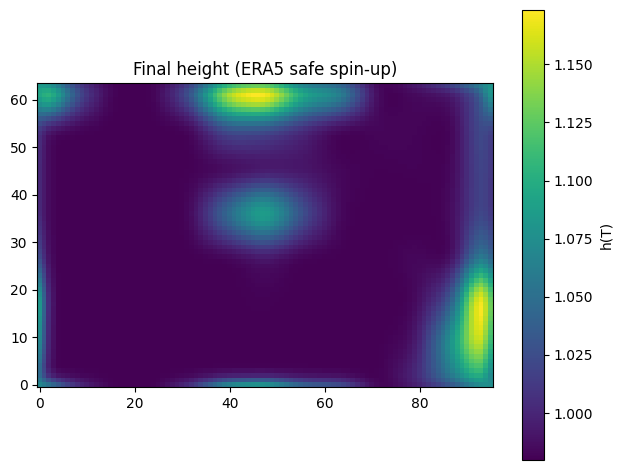

Done → outputs in: /Users/linearityproductions/Desktop/meteo_utils/outputs/era5_to_sw/real_ic_balanced


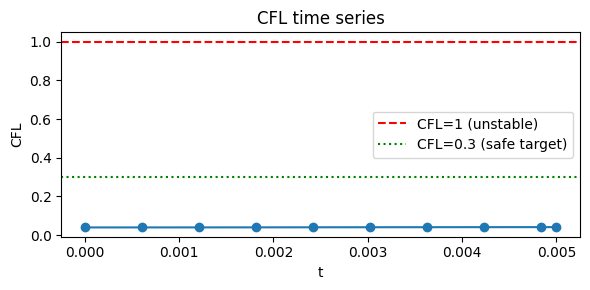

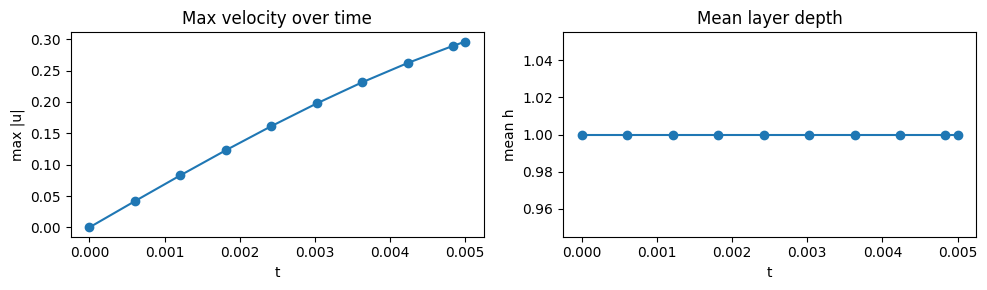

In [2]:
import sys
from pathlib import Path
import numpy as np
np.seterr(over='raise', invalid='raise')  # make warnings raise (debug)

# repo root
ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

import src.io.reanalysis as rea
from src.models.sw_adapter import rhs, sw_cfl
from src.models.sw_balance import geostrophic_uv_from_h, box_smooth
from src.runner import solve_fixed_step
import matplotlib.pyplot as plt, json

# 1) pick first NetCDF in data/
DATA_DIR = ROOT / "data"
nc_files = sorted(DATA_DIR.glob("*.nc"))
if not nc_files:
    raise FileNotFoundError(f"No .nc files found in {DATA_DIR}. Put your ERA5 file there.")
nc_path = nc_files[0]
print("Using NetCDF:", nc_path.name)

# 2) open and detect lon/lat
ds = rea.open_dataset(str(nc_path))
lon_name = "longitude" if "longitude" in ds.coords else ("lon" if "lon" in ds.coords else None)
lat_name = "latitude"  if "latitude"  in ds.coords else ("lat" if "lat" in ds.coords else None)
if lon_name is None or lat_name is None:
    raise ValueError(f"Couldn't find lon/lat coords in {list(ds.coords)}")

# 3) variable (prefer geopotential-like), 1 time slice
var_candidates = ["geopotential", "z", "gh", "height"]
var = next((v for v in var_candidates if v in ds.data_vars), None) or list(ds.data_vars)[0]
da = ds[var];  da = da.isel(time=0) if "time" in da.dims else da
print(f"Variable: {var}; dims={tuple(da.dims)} shape={tuple(da.shape)}")

# 4) subset Cyprus box (respect coord order; handle 0..360 lon)
lon_vals = ds[lon_name].values; lat_vals = ds[lat_name].values
use_0360 = (np.nanmax(lon_vals) > 180.0)
def conv_lon(l): return l % 360.0 if use_0360 else l
lon0, lon1, lat0, lat1 = 30.0, 36.0, 33.0, 36.5
lon0c, lon1c = conv_lon(lon0), conv_lon(lon1)
lon_asc = bool(lon_vals[0] <= lon_vals[-1]); lat_asc = bool(lat_vals[0] <= lat_vals[-1])
lon_slice = slice(min(lon0c, lon1c), max(lon0c, lon1c)) if lon_asc else slice(max(lon0c, lon1c), min(lon0c, lon1c))
lat_slice = slice(min(lat0, lat1), max(lat0, lat1))     if lat_asc else slice(max(lat0, lat1), min(lat0, lat1))
ds_sub = ds.sel({lon_name: lon_slice, lat_name: lat_slice})

# 5) reduce to 2D(lat,lon) and rename for interp
da_sub = ds_sub[var]
for d in list(da_sub.dims):
    if d not in (lat_name, lon_name):
        da_sub = da_sub.isel({d: 0})
da_sub = da_sub.squeeze(drop=True).transpose(lat_name, lon_name)
if lon_name != "longitude" or lat_name != "latitude":
    da_sub = da_sub.rename({lon_name: "longitude", lat_name: "latitude"})
if da_sub.ndim != 2 or da_sub.size == 0:
    raise ValueError(f"Expected 2D lat/lon field, got {tuple(da_sub.dims)} {tuple(da_sub.shape)}")

# 6) interpolate to (Ny,Nx)
field = rea.interp_to_grid(da_sub, Nx=Nx, Ny=Ny).astype(np.float64)

# --- Balanced IC build (but we’ll do a safe spin-up) ---
# convert geopotential → height (m) if needed
if var.lower() in {"geopotential", "z", "gh"}:
    field = field / float(g)

# gentle smoothing & rescale mean to h0
field = box_smooth(field, iters=1)
mean_field = float(np.mean(field))
if not np.isfinite(mean_field) or mean_field <= 0.0:
    raise ValueError("Mean ERA5 height invalid (non-finite or ≤ 0).")
h_ic = np.maximum((h0 / mean_field) * field, 1e-6)

# ===== OPTION A: GUARANTEED-STABLE SPIN-UP =====
# shrink anomaly amplitude to ±2% and zero winds
h_ic = h0 + 0.02 * (h_ic - float(np.mean(h_ic)))
h_ic = box_smooth(h_ic, iters=1)
h_ic = np.maximum(h_ic, 1e-6)
u0 = np.zeros_like(h_ic)
v0 = np.zeros_like(h_ic)

# strong damping/viscosity for spin-up
params["Du"] = max(params.get("Du", 0.0), 8e-3)
params["Dv"] = max(params.get("Dv", 0.0), 8e-3)
params["nu"] = max(params.get("nu", 0.0), 8e-4)

# strict dt from gravity waves; short horizon
dx_min   = min(dx, dy)
cmax0    = float(np.max(np.sqrt(g * h_ic)))
dt_local = 0.04 * dx_min / max(cmax0, 1e-12)  # strict
T_local  = 0.005

# 7) integrate
Y0b = np.stack([h_ic, u0, v0])
out_dir = ROOT / "outputs" / "era5_to_sw" / "real_ic_balanced"
out_dir.mkdir(parents=True, exist_ok=True)

sol2 = solve_fixed_step(
    f=rhs, t_span=(0.0, T_local), y0=Y0b, dt=dt_local, method="rk4",
    params=params, save_every=5, metrics_out_dir=out_dir,
    norm_grid=(dx, dy),
    cfl_specs={"gw": {"type": "advection", "dt": dt_local, "dx": dx_min,
                      "u": np.abs(Y0b[1]) + np.sqrt(g * Y0b[0])}},
)

# 8) artifacts + diagnostics
hT, uT, vT = sol2.y[-1]
np.savez(out_dir / "final_state.npz", h=hT, u=uT, v=vT)
plt.figure(); plt.imshow(hT, origin="lower"); plt.colorbar(label="h(T)")
plt.title("Final height (ERA5 safe spin-up)"); plt.tight_layout()
plt.savefig(out_dir / "h_final.png", dpi=160); plt.show()

ts = sol2.t
max_u = [np.max(np.sqrt(Y[1]*Y[1] + Y[2]*Y[2])) for Y in sol2.y]
mean_h = [float(np.mean(Y[0])) for Y in sol2.y]
cfls  = [sw_cfl(Y, params, dt_local) for Y in sol2.y]
np.savetxt(out_dir / "diag_t.csv", ts, delimiter=",")
np.savetxt(out_dir / "diag_max_u.csv", np.array(max_u), delimiter=",")
np.savetxt(out_dir / "diag_mean_h.csv", np.array(mean_h), delimiter=",")
np.savetxt(out_dir / "diag_cfl.csv", np.array(cfls), delimiter=",")

# metrics (avoid 'f' shadow)
mfile = out_dir / "metrics.json"
with mfile.open("r", encoding="utf-8") as fh:
    m = json.load(fh)
m.setdefault("extras", {})["mean_h_initial"] = float(mean_h[0])
m["extras"]["mean_h_range"] = float(max(mean_h) - min(mean_h))
m["extras"]["dt_used"] = float(dt_local)
with mfile.open("w", encoding="utf-8") as fh:
    json.dump(m, fh, indent=2)

print("Done → outputs in:", out_dir)

diag_dir = out_dir

t   = np.loadtxt(diag_dir / "diag_t.csv", delimiter=",")
cfl = np.loadtxt(diag_dir / "diag_cfl.csv", delimiter=",")
max_u = np.loadtxt(diag_dir / "diag_max_u.csv", delimiter=",")
mean_h = np.loadtxt(diag_dir / "diag_mean_h.csv", delimiter=",")

# CFL plot
plt.figure(figsize=(6,3))
plt.plot(t, cfl, marker='o')
plt.axhline(1.0, color='r', linestyle='--', label='CFL=1 (unstable)')
plt.axhline(0.3, color='g', linestyle=':', label='CFL=0.3 (safe target)')
plt.xlabel("t"); plt.ylabel("CFL"); plt.legend(); plt.title("CFL time series")
plt.tight_layout(); plt.show()

# Max velocity and mean h
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(t, max_u, marker='o')
plt.xlabel("t"); plt.ylabel("max |u|")
plt.title("Max velocity over time")

plt.subplot(1,2,2)
plt.plot(t, mean_h, marker='o')
plt.xlabel("t"); plt.ylabel("mean h")
plt.title("Mean layer depth")

plt.tight_layout(); plt.show()

# Balanced-winds run (geostrophy + conservative caps)

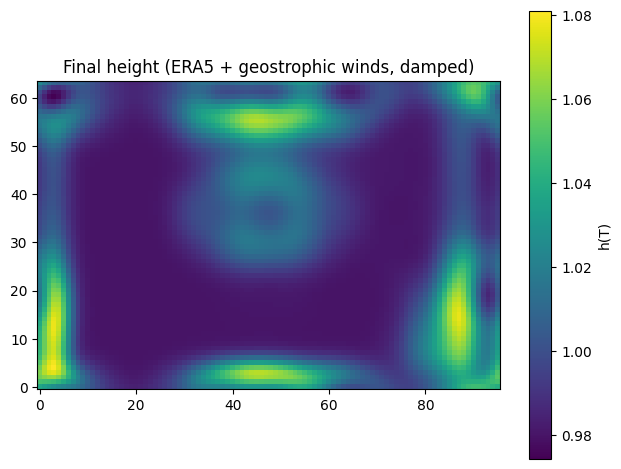

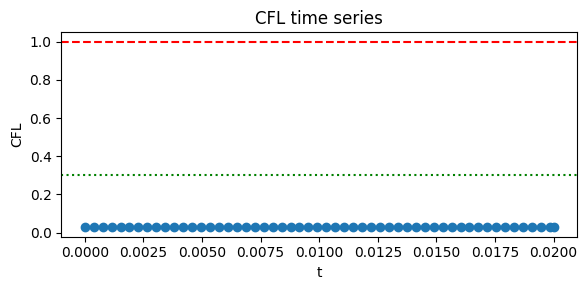

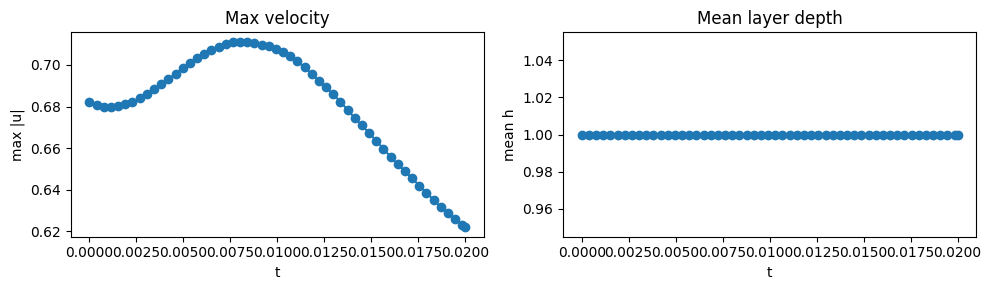

Done → /Users/linearityproductions/Desktop/meteo_utils/outputs/era5_to_sw/real_ic_balanced_gwind_v5


In [3]:
# --- Cell 3: Balanced-winds run (robust/damped) ---
import numpy as np
from pathlib import Path
from src.models.sw_balance import geostrophic_uv_from_h, box_smooth
from src.models.sw_adapter import rhs as rhs_base, sw_cfl
from src.runner import solve_fixed_step
import matplotlib.pyplot as plt, json

# local damped RHS wrapper (adds linear drag to momentum)
def rhs_damped(t, Y, p):
    dY = rhs_base(t, Y, p)       # calls rhs_sw_2d inside
    Du = p.get("Du", 0.0); Dv = p.get("Dv", 0.0)
    dY[1] -= Du * Y[1]
    dY[2] -= Dv * Y[2]
    return dY

# 0) smooth & clamp height
h_bal = box_smooth(h_ic, iters=2)
h_bal = np.maximum(h_bal, 1e-6)

# 1) geostrophic winds from h_bal
u0, v0 = geostrophic_uv_from_h(h_bal, g=g, f=f, dx=dx, dy=dy)
u0 = np.nan_to_num(u0, nan=0.0, posinf=0.0, neginf=0.0, copy=False)
v0 = np.nan_to_num(v0, nan=0.0, posinf=0.0, neginf=0.0, copy=False)

# 2) spin-up damping/viscosity
params["Du"] = max(params.get("Du", 0.0), 1.0e-2)
params["Dv"] = max(params.get("Dv", 0.0), 1.0e-2)
params["nu"] = max(params.get("nu", 0.0), 2.0e-3)

# 3) conservative dt from gravity-wave speed only, plus safety
dx_min  = min(dx, dy)
c_local = np.sqrt(g * h_bal)
cmax    = float(np.nanmax(c_local))
CFL_TGT = 0.05
dt_local = CFL_TGT * dx_min / max(cmax, 1e-12)
dt_local *= 0.5  # extra safety

# 4) hard-cap winds so advective speed is a fraction of c
umag = np.sqrt(u0*u0 + v0*v0)
umax = float(np.nanmax(umag))
if np.isfinite(umax) and umax > 0.0:
    target = 0.2 * cmax  # u should be <= 20% of c at start
    ratio  = umax / max(target, 1e-12)
    if ratio > 1.0:
        u0 /= ratio; v0 /= ratio

# 5) assemble & run short horizon
Y0b = np.stack([h_bal, u0, v0])
assert np.isfinite(Y0b).all(), "Non-finite in initial state"
T_local = 0.02

out_dir = ROOT / "outputs" / "era5_to_sw" / "real_ic_balanced_gwind_v5"
out_dir.mkdir(parents=True, exist_ok=True)

sol3 = solve_fixed_step(
    f=rhs_damped,                      # <-- use damped RHS
    t_span=(0.0, T_local),
    y0=Y0b,
    dt=dt_local,
    method="rk4",
    params=params,
    save_every=5,
    metrics_out_dir=out_dir,
    norm_grid=(dx, dy),
    cfl_specs={"gw": {"type": "advection",
                      "dt": dt_local,
                      "dx": dx_min,
                      "u": np.abs(Y0b[1]) + np.sqrt(g * Y0b[0])}},
)

# 6) artifacts + diagnostics
hT, uT, vT = sol3.y[-1]
np.savez(out_dir / "final_state.npz", h=hT, u=uT, v=vT)

plt.figure(); plt.imshow(hT, origin="lower"); plt.colorbar(label="h(T)")
plt.title("Final height (ERA5 + geostrophic winds, damped)"); plt.tight_layout()
plt.savefig(out_dir / "h_final.png", dpi=160); plt.show()

ts     = sol3.t
max_u  = [np.max(np.sqrt(Y[1]*Y[1] + Y[2]*Y[2])) for Y in sol3.y]
mean_h = [float(np.mean(Y[0])) for Y in sol3.y]
cfls   = [sw_cfl(Y, params, dt_local) for Y in sol3.y]

np.savetxt(out_dir / "diag_t.csv",      ts,               delimiter=",")
np.savetxt(out_dir / "diag_max_u.csv",  np.array(max_u),  delimiter=",")
np.savetxt(out_dir / "diag_mean_h.csv", np.array(mean_h), delimiter=",")
np.savetxt(out_dir / "diag_cfl.csv",    np.array(cfls),   delimiter=",")

plt.figure(figsize=(6,3))
plt.plot(ts, cfls, marker='o'); plt.axhline(0.3, ls=':', color='g'); plt.axhline(1.0, ls='--', color='r')
plt.xlabel("t"); plt.ylabel("CFL"); plt.title("CFL time series")
plt.tight_layout(); plt.savefig(out_dir / "diag_cfl.png", dpi=160); plt.show()

plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.plot(ts, max_u, marker='o'); plt.xlabel("t"); plt.ylabel("max |u|"); plt.title("Max velocity")
plt.subplot(1,2,2); plt.plot(ts, mean_h, marker='o'); plt.xlabel("t"); plt.ylabel("mean h"); plt.title("Mean layer depth")
plt.tight_layout(); plt.savefig(out_dir / "diag_timeseries.png", dpi=160); plt.show()

# 7) metrics update (safe)
mfile = out_dir / "metrics.json"
try:
    with mfile.open("r", encoding="utf-8") as fh:
        m = json.load(fh)
except FileNotFoundError:
    m = {}
m.setdefault("extras", {})["mean_h_initial"] = float(mean_h[0])
m["extras"]["mean_h_range"] = float(max(mean_h) - min(mean_h))
m["extras"]["dt_used"] = float(dt_local)
m["extras"]["cfl_max"] = float(np.max(cfls))
with mfile.open("w", encoding="utf-8") as fh:
    json.dump(m, fh, indent=2)

print("Done →", out_dir)